In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 356 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# Importing Libraries

In [66]:
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, LSTM
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Getting Data
Stock price data with yahoo finance api for the last 10 years.

In [4]:
company_name_list = ['MSFT', 'TSLA', 'CRM', 'AAL']
start_time = datetime(2012,1,1)
end_time = datetime.now()
for list_stock in company_name_list:
    globals()[list_stock] = yf.download(list_stock, start_time, end_time)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
symbol_list = [MSFT, TSLA, CRM, AAL]
company_name_list = ["Microsoft", "Tesla", "Saleforce", "American_Airlines"]

for company, company_name_list in zip(symbol_list, company_name_list):
    company["company_name_list"] = company_name_list
    
df = pd.concat(symbol_list, axis=0)
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,company_name_list
Date,,,,,,,
2012-01-03,26.549999,26.959999,26.389999,26.770000,21.466702,64731500,Microsoft
2012-01-04,26.820000,27.469999,26.780001,27.400000,21.971889,80516100,Microsoft
2012-01-05,27.379999,27.730000,27.290001,27.680000,22.196426,56081400,Microsoft
2012-01-06,27.530001,28.190001,27.530001,28.110001,22.541241,99455500,Microsoft
2012-01-09,28.049999,28.100000,27.719999,27.740000,22.244535,59706800,Microsoft
2012-01-10,27.930000,28.150000,27.750000,27.840000,22.324724,60014400,Microsoft
2012-01-11,27.430000,27.980000,27.370001,27.719999,22.228497,65582400,Microsoft
2012-01-12,27.870001,28.020000,27.650000,28.000000,22.453032,49370800,Microsoft
2012-01-13,27.930000,28.250000,27.790001,28.250000,22.653502,60196100,Microsoft


In [6]:
microsoft=df[df['company_name_list']=='Microsoft']

In [7]:
microsoft.drop(columns='company_name_list',inplace=True)

In [8]:
microsoft.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,26.549999,26.959999,26.389999,26.770000,21.466702,64731500
2012-01-04,26.820000,27.469999,26.780001,27.400000,21.971889,80516100
2012-01-05,27.379999,27.730000,27.290001,27.680000,22.196426,56081400
2012-01-06,27.530001,28.190001,27.530001,28.110001,22.541241,99455500
2012-01-09,28.049999,28.100000,27.719999,27.740000,22.244535,59706800


In [9]:
microsoft.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2748.000000,2748.000000,2748.000000,2748.000000,2748.000000,2.748000e+03
mean,112.519058,113.633701,111.352584,112.550833,107.916324,3.370563e+07
std,89.285393,90.256770,88.237804,89.291720,90.263593,1.748703e+07
min,26.379999,26.629999,26.260000,26.370001,21.466702,7.425600e+06
25%,42.870001,43.192500,42.504999,42.907500,37.484098,2.288150e+07
50%,70.099998,70.615002,69.614998,70.049999,65.289631,2.958935e+07
75%,168.002499,171.252495,165.682495,167.875004,163.423470,3.918955e+07
max,344.619995,349.670013,342.200012,343.109985,339.924805,2.484285e+08


In [10]:
microsoft.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

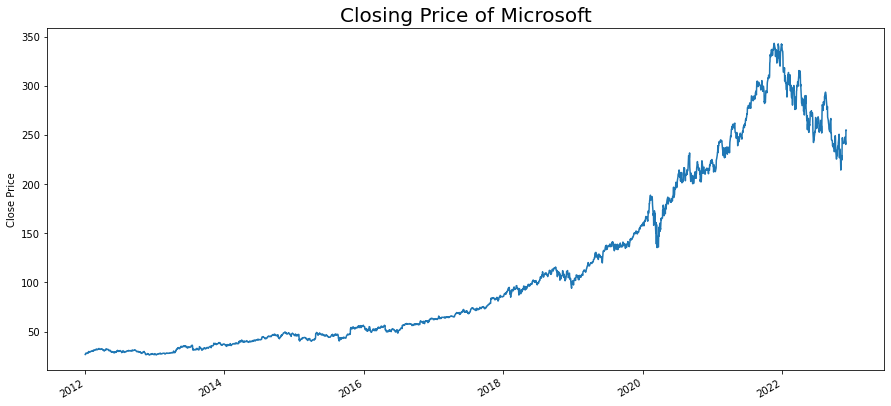

In [31]:
plt.figure(figsize=(15,7))
microsoft.Close.plot(kind='line')
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title("Closing Price of Microsoft",fontsize=20)
plt.show()

# Preprocessing

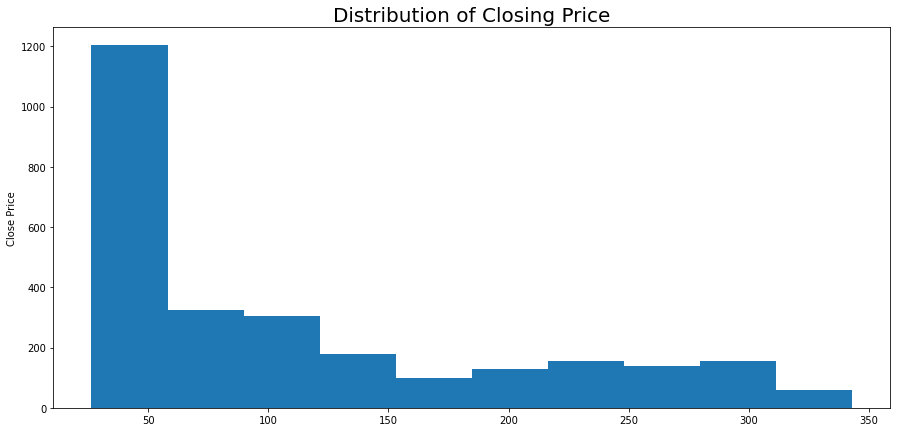

In [33]:
plt.figure(figsize=(15,7))
microsoft.Close.plot(kind='hist')
plt.ylabel('Close Price')
plt.xlabel(None)
plt.title("Distribution of Closing Price",fontsize=20)
plt.show()

In [12]:
dataset = microsoft.filter(['Close']).values
training_data_len = int(np.ceil( len(dataset) * .95 ))
training_data_len

2611

In [13]:
#scaling data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00126286],
       [0.00325187],
       [0.00413588],
       ...,
       [0.67550676],
       [0.72226435],
       [0.72084363]])

# Train Test Split
Train test split is a model validation procedure that reveals how your model performs on new data.

In [14]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []
for value in range(60, len(train_data)):
    x_train.append(train_data[value-60:value, 0])
    y_train.append(train_data[value, 0])

In [15]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [35]:
#Buildin the LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
# Second LSTM layer
model.add(LSTM(64, return_sequences=False))
# Third LSTM layer
model.add(Dense(25))
# The output layer
model.add(Dense(1))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
# Compile 
model.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
#Last step.Fit model to the train set
model.fit(x_train, y_train, batch_size=1, epochs=1)

2551/2551 [==============================] - 108s 41ms/step - loss: 0.0011


In [47]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for value in range(60, len(test_data)):
    x_test.append(test_data[value-60:value, 0])

In [48]:
# Convert the data to a numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [49]:
# Get the models predicted price values 
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)

5/5 [==============================] - 1s 36ms/step


In [50]:

print('Mean Absolute Error: ', mean_absolute_error(y_test, prediction))
print('Mean Squared Error: ', mean_squared_error(y_test, prediction))

Mean Absolute Error:  9.499679454051666
Mean Squared Error:  135.72542187814892


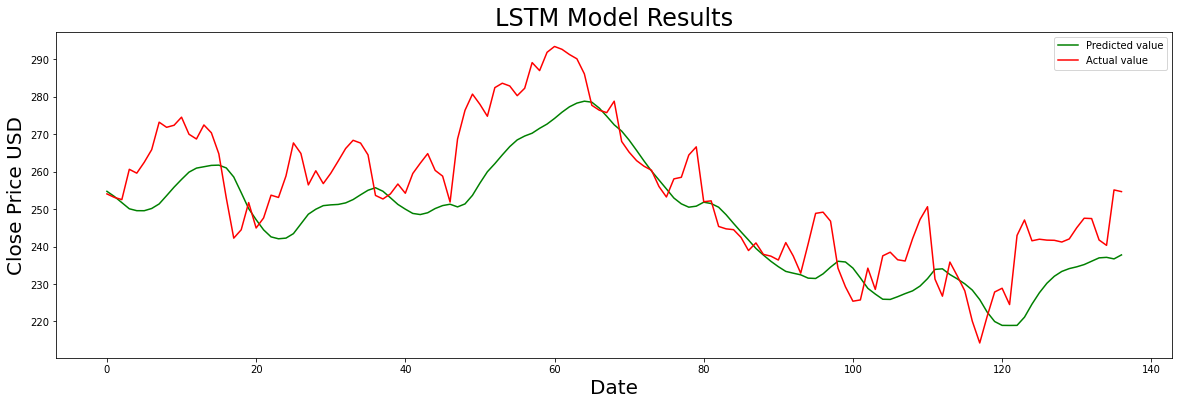

In [72]:
plt.figure(figsize=(20,6))
plt.plot(prediction, color='green', label='Predicted value')
plt.plot(y_test, color ='red', label='Actual value')
plt.title('LSTM Model Results',fontsize=24)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize=20)
plt.legend()
plt.show()

In [56]:

data=microsoft['Close']
data.head()

Date
2012-01-03    26.770000
2012-01-04    27.400000
2012-01-05    27.680000
2012-01-06    28.110001
2012-01-09    27.740000
Name: Close, dtype: float64

In [67]:
time = np.arange(len(data.index))
data['time'] = time 

In [68]:
X = data.loc[:,["time"]]
y = data.loc[:,"Close"] 
model = LinearRegression()
# Train the model
model.fit(X, y)
#Store the fitted values as a time series with the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

# Plotting the result

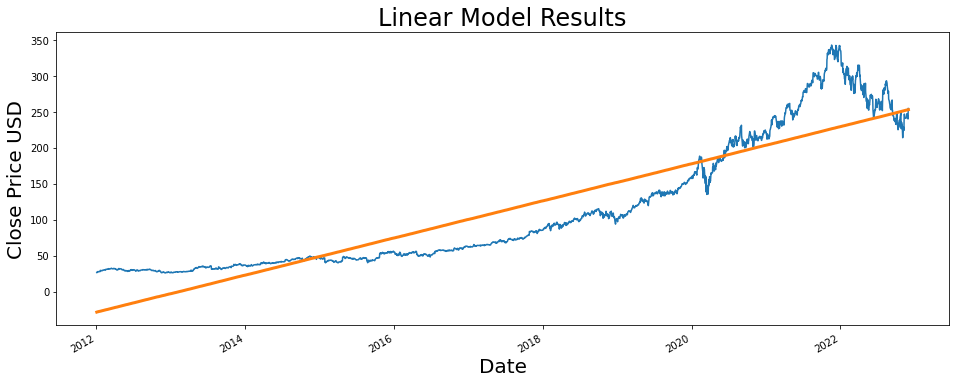

In [75]:
plt.figure(figsize=(16,6))
ax = y.plot()
ax = y_pred.plot(ax=ax, linewidth=3)
plt.title('Linear Model Results',fontsize=24)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize=20)
plt.show()